In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pickle
import numpy as np
import cv2
import glob
from pathlib import Path
import matplotlib.pyplot as plt

from moviepy.editor import VideoFileClip
from IPython.display import HTML

import utils

In [3]:
save_image = True

In [4]:
with open("./output_data/camera_calibration.p", 'rb') as f:
    calibration = pickle.load(f)

mtx, dist = calibration["mtx"], calibration["dist"]

with open("./output_data/warp_matrix.p", 'rb') as f:
    warp_matrix = pickle.load(f)

M, M_inv = warp_matrix["M"], warp_matrix["M_inv"]

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

left_line = utils.Line()
right_line = utils.Line()
fitting_info = {"ok": False}
debug_dict = {}
curve_hist = []

process_info = {"left_line": utils.Line(), "right_line": utils.Line()}

def process_image(image):
    """
    This method apply some preprocessing technique to the given image
    
    - Undistort image by using camera calibartion result
    - Binarize RGB color image
    - Apply perspective transformation
    - Fit lane area by using  quadratic function
    - Apply inverse transformation
    """
    
    # undistort image
    img_undistort = cv2.undistort(image, mtx, dist, None, mtx)

    # warp image
    img_warp = utils.warp_img(img_undistort, M)
    
    # binarize image
    img_binary, img_bins = utils.combined_thresh(img_warp)
    
    #  fit lane
    if(not fitting_info["ok"]):
        try:
            fit_result = utils.fit_lane(img_binary)
            fit_result = utils.update_fit_lane(img_binary, fit_result["left_fit"], fit_result["right_fit"])            
            fitting_info["ok"] = True
                
        except utils.EmptyDataError:            
            return image
    else:
        try:
            left_line, right_line = process_info["left_line"], process_info["right_line"]
            fit_result = utils.update_fit_lane(img_binary, left_line.best_fit, right_line.best_fit)
            fitting_info["ok"] = True
            
        except utils.EmptyDataError:
            fitting_info["ok"] = False
            return process_image(image)
    
    ## detected pixcels
    img_detected = fit_result["out_img"]
    
    ## update lines
    left_line, right_line = process_info["left_line"], process_info["right_line"]
    left_res = left_line.update_line(fit_result["leftx"], fit_result["lefty"], fit_result["left_fitx"], fit_result["left_fit"])
    right_res = right_line.update_line(fit_result["rightx"], fit_result["righty"], fit_result["right_fitx"], fit_result["right_fit"])
    if not(left_res and right_res):
        fitting_info["ok"] = False
            
    ## measure curvature and position
    ploty = fit_result["ploty"]
    y_eval = np.max(ploty)
    vihecle_center = (img_detected.shape[1]/2) * xm_per_pix
    left_line.measure_curvature_and_position(y_eval, xm_per_pix, ym_per_pix)
    right_line.measure_curvature_and_position(y_eval, xm_per_pix, ym_per_pix)
    
    lane_center = (left_line.line_pos + right_line.line_pos) / 2.0
    distance_from_center = vihecle_center - lane_center

    ## create fitted region
    fit_region_img = utils.draw_region(np.zeros_like(image), left_line.best_fit_line(ploty), right_line.best_fit_line(ploty), ploty)
    fit_region_img = utils.warp_img(fit_region_img, M_inv)    
    result = utils.weighted_img(fit_region_img, image, alpha=1, beta=0.3)
    
    
    w, h = (128*3, 72*3)
    result[:h,                : 1*w] = cv2.resize(img_warp, (w, h))
    result[:h,     w+5   : 2*w+5] = cv2.cvtColor(255*cv2.resize(img_binary, (w, h)),cv2.COLOR_GRAY2RGB)
    result[:h, 2*w+10 : 3*w+10] = cv2.resize(img_detected, (w, h))

    left_curverad = left_line.radius_of_curvature
    right_curverad = right_line.radius_of_curvature
    curve_text = "curvature (left/right) : {0:.2f}m / {1:.2f}m ".format(left_curverad, right_curverad)
    cv2.putText(result, curve_text, (0, h+50), cv2.FONT_HERSHEY_COMPLEX, 1.2, (255, 255, 255), 2)
    
    pos_text = "distance from center: {0:.2f}m ".format(distance_from_center)
    cv2.putText(result, pos_text, (0, h+100), cv2.FONT_HERSHEY_COMPLEX, 1.2, (255, 255, 255), 2)

    
    return result

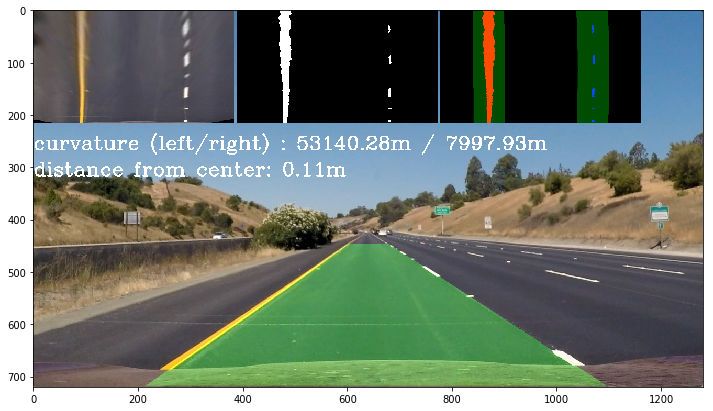

In [5]:
img = cv2.cvtColor(cv2.imread("test_images/straight_lines1.jpg"), cv2.COLOR_BGR2RGB)
vihecle_center = img.shape[1]/2
res = process_image(img)

plt.figure(figsize=(12, 8))
plt.imshow(res)

if save_image:
    plt.savefig("./output_images/process_image_example.png", bbox_inches="tight")

In [6]:
white_output = 'output_video/project_solution.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip = VideoFileClip("project_video.mp4").subclip(30, 45)
clip = VideoFileClip("project_video.mp4")
print(clip.fps)
clip = clip
white_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

25.0
[MoviePy] >>>> Building video output_video/project_solution.mp4
[MoviePy] Writing video output_video/project_solution.mp4


100%|█████████▉| 1260/1261 [02:39<00:00,  8.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_solution.mp4 

CPU times: user 2min 57s, sys: 8.73 s, total: 3min 6s
Wall time: 2min 40s


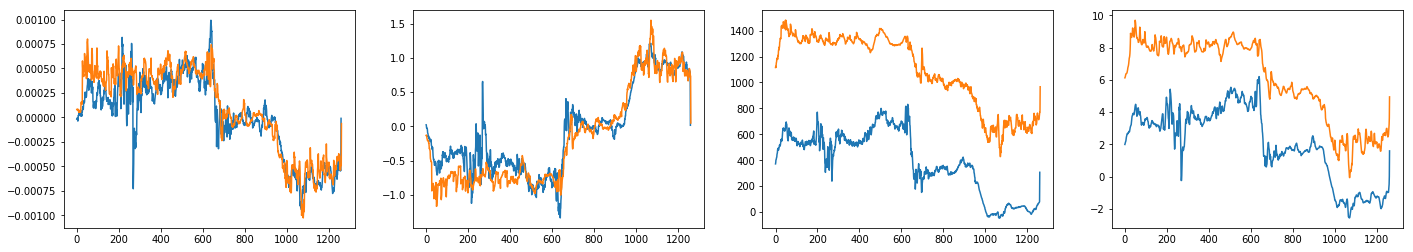

In [7]:
left_line = process_info["left_line"]
right_line = process_info["right_line"]


plt.figure(figsize=(24, 4))
ax = plt.subplot(1, 4, 1)
plt.plot(np.array(left_line.fit_history)[:, 0])
plt.plot(np.array(right_line.fit_history)[:, 0])

ax = plt.subplot(1, 4, 2)
plt.plot(np.array(left_line.fit_history)[:, 1])
plt.plot(np.array(right_line.fit_history)[:, 1])

ax = plt.subplot(1, 4, 3)
plt.plot(np.array(left_line.fit_history)[:, 2])
plt.plot(np.array(right_line.fit_history)[:, 2])

ax = plt.subplot(1, 4, 4)
plt.plot(np.array(left_line.line_x_pos_history))
plt.plot(np.array(right_line.line_x_pos_history))


In [8]:
white_output = 'output_video/challenge_solution.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip = VideoFileClip("challenge_video.mp4")
#clip = clip.set_fps(5)
white_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_video/challenge_solution.mp4
[MoviePy] Writing video output_video/challenge_solution.mp4


100%|██████████| 485/485 [00:49<00:00,  9.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/challenge_solution.mp4 

CPU times: user 1min 8s, sys: 2.33 s, total: 1min 11s
Wall time: 50 s


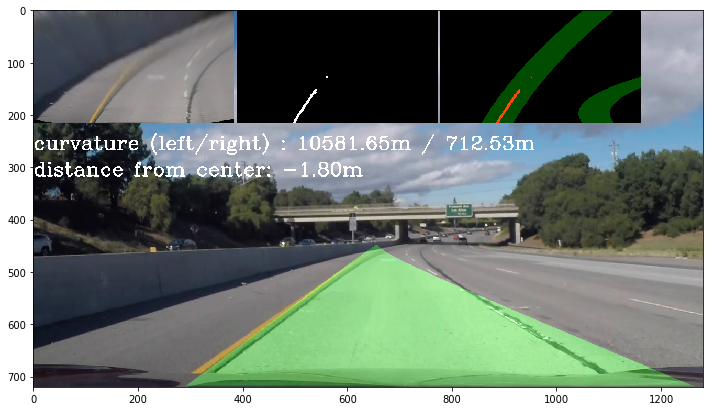

In [9]:
img = clip.get_frame(0.5)
plt.figure(figsize=(12, 8))
img = process_image(img)
plt.imshow(img)

if save_image:
    plt.savefig("./output_images/challange_example.png", bbox_inches="tight")